## Import Packages

In [2]:
# import packages
# Importing all necessary packages

import numpy as np
import pandas as pd
#from sklearn.decomposition import PCA
import collections
from sklearn.model_selection import train_test_split

# importing os module
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
#import shap
import random
import scipy.stats

import warnings
warnings.filterwarnings("ignore")

## Functions

#### 1. Split Function: Splits the data into train and test

x: input

y:output

In [3]:
def split(x, y, random_state): # x and y are raw
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=random_state)
    # data without imputation and target values
    return x_train, x_test, y_train, y_test # _0 retaines sample type information _1 are without sample type info

#### 2. Random Selection: randomly selects a set of n features

In [4]:
def random_selection(num, all_features, random_state):
    # num is the feature set size to be selected
    # all_features = total pool of features
    # random selection of columns
    random.seed(random_state)
    features = []
    features = random.sample(all_features, num)
    return features

3. Min-Max Scaling


In [5]:
def minmax_scaling(x_train, x_test):

    scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns, index=x_train.index)
    x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)
    return x_train, x_test


In [6]:
def impute(x_train, x_test):
    imputer = KNNImputer(n_neighbors=5)
    imputer.fit(x_train)
    x_train = pd.DataFrame(imputer.transform(x_train), columns=x_train.columns, index=x_train.index)
    x_test = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns, index=x_test.index)
    return x_train, x_test

Evaluation

In [7]:
def eval(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, pos_label = "Tumor")
    precision = precision_score(y_true,y_pred, pos_label = "Tumor")
    recall = recall_score(y_true, y_pred, pos_label = "Tumor")
    auc = roc_auc_score(y_true, y_pred)
    return acc, f1, precision, recall

### BOXplot for model performance for selected vs random geneset

In [16]:
def measure_boxplot(df_measure_imp, df_measure_random, filepath, title):
    df_imp_long = df_measure_imp.melt(var_name="Model", value_name="Accuracy")
    df_imp_long["Type"] = "Important"
    df_rand_long = df_measure_random.melt(var_name="Model", value_name="Accuracy")
    df_rand_long["Type"] = "Random"
    df_all = pd.concat([df_imp_long, df_rand_long], ignore_index= True)

    # calculating p-val
    p_cv_logr = float(scipy.stats.wilcoxon(df_measure_imp["LogR"], df_measure_random["LogR"],alternative = "greater")[1])
    #print(p_cv_logr)
    p_cv_RF = float(scipy.stats.wilcoxon(df_measure_imp["RF"], df_measure_random["RF"], alternative = "greater")[1])
    #print(p_cv_RF)
    p_cv_MLP = float(scipy.stats.wilcoxon(df_measure_imp["MLP"], df_measure_random["MLP"], alternative = "greater")[1])
    #print(p_cv_MLP)
    p_cv_SVC = float(scipy.stats.wilcoxon(df_measure_imp["SVC"], df_measure_random["SVC"], alternative = "greater")[1])
    #print(p_cv_SVC)
    pvals = {"LogR":p_cv_logr, "RF":p_cv_RF, "MLP":p_cv_MLP, "SVC": p_cv_SVC}
    plt.figure(figsize=(8,6))
    ax = sns.boxplot(x="Model", y="Accuracy", hue="Type", data=df_all, palette="Set2")

    # Add p-values above boxes
    for i, model in enumerate(df_all["Model"].unique()):
        y = df_all[df_all["Model"]==model]["Accuracy"].max() + 0.002  # position above box
        p = pvals[model]
        ax.text(i, y, f"p = {p:.3e}", ha="center", va="bottom", fontsize=10, color="black")

    plt.title(title)
    plt.ylabel("Accuracy")
    plt.legend(title="Gene Set")    
    plt.savefig(filepath, dpi = 400)


#### Classification task

In [9]:
def classification_task(x_train, x_test, y_train, y_test, models, model_names, random_state):
        
        # accuracy dictionary
        accuracy_cv = {} # iteration over seeds
        accuracy_pred = {} # iteration over seeds
      
        i = 0
        for est in models: 
                model_name = model_names[i]
                i = i + 1
                est = est.fit(x_train, y_train)

                #  Stratified Cross validation
                cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = random_state)
                y_pred_CV = cross_val_predict(est, x_train, y_train, cv=cv)               
                report_CV = classification_report(y_train, y_pred_CV, target_names=["Normal", "Tumor"], output_dict=True)
                acc = report_CV["accuracy"]
                accuracy_cv[model_name] = acc


                # prediction
                y_pred = est.predict(x_test)

                report = classification_report(y_test, y_pred, target_names=["Normal", "Tumor"], output_dict=True)
                acc = report["accuracy"]
                accuracy_pred[model_name] = acc
                # returns directory for models
        return accuracy_cv, accuracy_pred

### Classification on final geneset

### Feature Selection:Mutual Information

In [10]:
def get_miscores(X, y, random_state):
    mi_scores = mutual_info_classif(X, y, random_state=random_state)
    return mi_scores
def get_migenes(x, y, k, random_state):
    mi_df  = pd.DataFrame(columns=["gene", "MI_score"])
    mi_df["gene"] = x.columns
    random.seed(random_state)
    seeds = random.sample(range(0, 1000), 3)
    for seed in seeds: # you can increase the list of seeds
        mi_scores= get_miscores(x, y, random_state=seed)
        mi_df[seed] = mi_scores
        # Mi_score column is mean of all seeds
    mi_df["MI_score"] = mi_df.iloc[:, 1:4].mean(axis=1)

    mi_df = mi_df.sort_values(by="MI_score", ascending=False)
        
    top_1000_df = mi_df.head(k)
    top_genes_mi = mi_df["gene"].tolist()[:k]
    
    # returns the list and dataframe
    return top_genes_mi, top_1000_df 


### Feature Selection: RF-SelectFromModel

In [11]:
def RFSFM(x_train, x_test,y_train, y_test, random_state):
    # Using RandomForestClassifier as the estimator
    rf = RandomForestClassifier(n_estimators=500, random_state=random_state)
    # Using SelectFromModel to select top 100 features
    selector = SelectFromModel(rf, max_features=100, threshold="median")
    selector.fit(x_train, y_train)
    selected_features = x_train.columns[selector.get_support()]
    x_train_rf = x_train[selected_features]
    x_test_rf = x_test[selected_features]
    return x_train_rf, x_test_rf, selected_features

### Feature Selection: SVMRFE

In [12]:
def svm_rfe(x_train, y_train, features, random_state): # returns dataframe of features 
    # min = min numbers of features to be selected
    
    # cross validation to be used in RFECV
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = random_state)
    
    # using SVC estimator to check Features importance using RFE 
    svc = svm.SVC(kernel = "linear", random_state=random_state)
    # RFECV optimizes the minimum set of features needed for cassification task
    rfecv_SVM = RFECV(svc, min_features_to_select = 20, cv=cv, scoring='f1_weighted',  n_jobs=-1)
    fit_rfecv_SVM = rfecv_SVM.fit(x_train, y_train)
    
    RFECV_SVM_Top_Feat_df = pd.DataFrame({'Features': features, 'Selected': fit_rfecv_SVM.support_,
                                  'Rank': fit_rfecv_SVM.ranking_})
    RFECV_SVM_Top_Feat_df = RFECV_SVM_Top_Feat_df.sort_values(by = 'Rank')
 
    return RFECV_SVM_Top_Feat_df
    
    
    
    

#### Ploting ROC

In [13]:
# function to plot ROC curve
def roc(model_list, x_test, y_test):
    disp = RocCurveDisplay.from_estimator(model_list[0], x_test, y_test, pos_label='Tumor', name ="LogR", lw = 5)
    RocCurveDisplay.from_estimator(model_list[1], x_test, y_test, pos_label='Tumor', ax=disp.ax_, name ="RF", lw = 5);
    RocCurveDisplay.from_estimator(model_list[2], x_test, y_test, pos_label='Tumor', ax=disp.ax_, name ="MLP", lw = 5);
    RocCurveDisplay.from_estimator(model_list[3], x_test, y_test, pos_label='Tumor', ax=disp.ax_, name ="SVC", lw = 5); 
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.rc("font", size = 20)
    plt.legend(fontsize = "16", frameon = False)
    plt.title("100 genes (ANOVA)")
    plt.savefig("00-1_ROC_Top_100_Cancer.png", dpi=400, bbox_inches='tight')
    plt.show()


## MAIN

### Getting the data ready for the main process

In [2]:
data_df = pd.read_csv("data/processed/All_processed.csv", index_col=0)
print(data_df.shape)
x = data_df.drop(columns=["PP_Sample_Type"])
y = data_df["PP_Sample_Type"]


(131, 52024)


In [13]:
data_df.head(5)

,T_A1BG,T_A1BG-AS1,T_A1CF,T_A2M,T_A2M-AS1,T_A2ML1,T_A2MP1,T_A3GALT2,T_A4GALT,T_A4GNT,...,PP_ZSCAN22,PP_ZSCAN29,PP_ZSCAN5A,PP_ZSWIM8,PP_ZWILCH,PP_ZXDC,PP_ZYX,PP_ZZEF1,PP_ZZZ3,PP_Sample_Type
C3N-03456,6.21,6.29,2.60,13.24,5.98,12.65,1.62,0.00,8.72,3.74,...,17.603104,21.864414,19.686263,25.011367,NaN,NaN,26.172740,23.730765,23.099144,Tumor
C3N-02714,5.96,7.35,4.92,14.27,6.93,13.19,3.03,0.00,9.45,1.71,...,NaN,21.586324,NaN,24.692397,17.797377,19.304699,26.537361,24.145377,22.703406,Tumor
C3N-03015,6.63,6.78,4.01,13.91,5.80,13.87,2.47,0.00,9.53,0.89,...,17.930423,21.618961,20.157563,24.735180,17.210738,19.427874,26.617454,24.093594,23.235002,Tumor
C3N-01947,5.67,6.58,5.37,15.33,7.58,8.47,3.88,2.38,8.82,2.86,...,18.033872,21.586480,19.931675,24.832460,17.789706,18.905021,26.247921,23.962779,22.881750,Tumor
C3N-01754,6.11,7.64,3.46,13.38,6.17,14.10,2.80,0.00,9.56,1.31,...,17.577083,21.568303,20.146828,24.651994,16.973004,18.505719,26.495830,23.993061,22.959347,Tumor


In [14]:
# check if missing values are present
data_df.isnull().sum().sum()

np.int64(109804)

## MAIN LOOP -- Loops for 100 random states

In [ ]:
# iteration of random seeds

# dictionaries to store results
# dict to store selected genes from MI and SVM-RFE
# dtaaframe to store results
dict_mi = {}
dict_svmrfe = {}
dict_rfsfm = {}
dict_acc_cv = {"LogR":[], "RF":[], "MLP":[], "SVC":[]}
dict_acc_pred = {"LogR":[], "RF":[], "MLP":[], "SVC":[]}
dict_acc_cv_random = {"LogR":[], "RF":[], "MLP":[], "SVC":[]}
dict_acc_pred_random = {"LogR":[], "RF":[], "MLP":[], "SVC":[]}
for i in range(100):
    random_state = i
    print("------------------------------------------------------------------")
    print("Iteration: ", i+1)
    print ("Random state: ", random_state)
    # train-test split
    x_train, x_test, y_train, y_test = split(x,y,random_state)

    # imputation of missing values
    x_train, x_test = impute(x_train, x_test)

    # Min-Max Scaling
    x_train, x_test = minmax_scaling(x_train, x_test)

    # Mutual Information based feature selection -- gives top 1000 genes
    top_genes_mi, top_1000_df = get_migenes(x_train, y_train, 1000, random_state)
    dict_mi[random_state] = top_genes_mi

    print("Top 1000 genes selected using MI")
   
    # updated x_train and x_test
    x_train_mi = x_train[top_genes_mi]
    x_test_mi = x_test[top_genes_mi]
    
    # Random forest based feature selection -- gives top 100 genes using SlectFromModel
    x_train_rfsfm, x_test_rfsfm, features_rfsfm = RFSFM(x_train_mi, x_test_mi, y_train, y_test, random_state)
    dict_rfsfm[random_state] = features_rfsfm.tolist()
    print("Top genes selected using RF-SelectFromModel: ", len(features_rfsfm))
    

    # SVM-RFE based feature selection -- gives top genes selected by SVM-RFE (not a fixed range)
    svm_rfe_df = svm_rfe(x_train_rfsfm, y_train, features_rfsfm, random_state) # returns dataframe of features (all features with selected True/False)

# selected features from SVM-RFE
    features_svmrfe = svm_rfe_df [svm_rfe_df['Selected'] == True]['Features'].tolist()
    dict_svmrfe[random_state] = features_svmrfe

    print("Top genes selected using SVM-RFE: ", len(features_svmrfe))

    # updated x_train and x_test
    x_train_svmrfe = x_train_rfsfm[features_svmrfe]
    x_test_svmrfe = x_test_rfsfm[features_svmrfe]

    # running 4 classifiers for evaltuion
    logr = LogisticRegression(random_state=random_state, max_iter=800, solver='liblinear')
    rf = RandomForestClassifier(random_state=random_state, n_estimators=500)
    mlp = MLPClassifier(random_state=random_state, max_iter=800, activation="relu", solver='lbfgs', alpha=1e-5)
    svc = SVC(random_state=random_state, kernel = "linear", C = 0.1)


    models = [logr, rf, mlp, svc]
    model_names = ["LogR", "RF", "MLP", "SVC"]

    # returns dictionary for models
    acc_cv, acc_pred = classification_task(x_train_svmrfe, x_test_svmrfe, y_train, y_test, models, model_names, random_state)    
    for key in acc_cv.keys():
        dict_acc_cv[key].append(acc_cv[key])
    for key in acc_pred.keys():
        dict_acc_pred[key].append(acc_pred[key])
        print(f"Accuracy for mode {key}: {acc_pred[key]}")

    print("Classification task using SVM-RFE selected genes done")

# random features for comparison

    num_features = len(features_svmrfe)
    all_features = x.columns.tolist()
    random_features = random_selection(num_features, all_features, random_state)
    x_train_random = x_train[random_features]
    x_test_random = x_test[random_features]

    # classification task
    acc_cv, acc_pred = classification_task(x_train_random, x_test_random, y_train, y_test, models, model_names, random_state)    
    for key in acc_cv.keys():
        dict_acc_cv_random[key].append(acc_cv[key])
    for key in acc_pred.keys():
        dict_acc_pred_random[key].append(acc_pred[key])
        print(f"Accuracy for mode {key}: {acc_pred[key]}")

    print("Classification task using Randomly selected genes done")





------------------------------------------------------------------
Iteration:  1
Random state:  0
Top 1000 genes selected using MI
Top genes selected using RF-SelectFromModel:  100
Top genes selected using SVM-RFE:  38
Accuracy for mode LogR: 1.0
Accuracy for mode RF: 1.0
Accuracy for mode MLP: 1.0
Accuracy for mode SVC: 1.0
Classification task using SVM-RFE selected genes done
Accuracy for mode LogR: 1.0
Accuracy for mode RF: 0.9629629629629629
Accuracy for mode MLP: 1.0
Accuracy for mode SVC: 1.0
Classification task using Randomly selected genes done
------------------------------------------------------------------
Iteration:  2
Random state:  1
Top 1000 genes selected using MI
Top genes selected using RF-SelectFromModel:  100
Top genes selected using SVM-RFE:  20
Accuracy for mode LogR: 1.0
Accuracy for mode RF: 1.0
Accuracy for mode MLP: 1.0
Accuracy for mode SVC: 1.0
Classification task using SVM-RFE selected genes done
Accuracy for mode LogR: 0.9259259259259259
Accuracy for mode

In [16]:
# saving results

#-----genes--------------
# MI selected genes --fixed number 1000
df_mi_df = pd.DataFrame()
for key in dict_mi.keys():
    df_mi_df[key] = dict_mi[key]
df_mi_df.to_csv("results/MO/00-1_Top_1000_genes_MI_MO.csv")

#RFSFM Selected genes -- number can vary 
df_rfsfm = pd.DataFrame()
for key in dict_rfsfm.keys():
    df_rfsfm[key] = [dict_rfsfm[key]]
df_rfsfm.to_csv("results/MO/00-1_Top_genes_RFSFM_MO.csv")

# SVMRFE selected gene -- number can vary
df_svmrfe = pd.DataFrame()
for key in dict_svmrfe.keys():
    df_svmrfe[key] = [dict_svmrfe[key]]
df_svmrfe.to_csv("results/MO/00-1_Top_genes_SVMRFE_MO.csv") 


#-------performance measures -------------

# Cross validation SVMRFE
df_acc_cv = pd.DataFrame(dict_acc_cv)
df_acc_cv.to_csv("results/MO/00-1_Accuracy_CV_SVMRFE_MO.csv")

# Test SVMRFE
df_acc_pred = pd.DataFrame(dict_acc_pred)
df_acc_pred.to_csv("results/MO/00-1_Accuracy_Pred_SVMRFE_MO.csv")

# Cross Validation Random
df_acc_cv_random = pd.DataFrame(dict_acc_cv_random)
df_acc_cv_random.to_csv("results/MO/00-1_Accuracy_CV_Random_MO.csv")

# Test Random
df_acc_pred_random = pd.DataFrame(dict_acc_pred_random)
df_acc_pred_random.to_csv("results/MO/00-1_Accuracy_Pred_Random_MO.csv")

## FINAL results over selected gene set

### SVMRFE

In [17]:
# finding the most reoccuring top 10 genes from SVMRFE
num = []
dict_gene_freq = {}

for key in dict_svmrfe.keys():
    num.append(len(dict_svmrfe[key]))
    for gene in dict_svmrfe[key]:
        if gene in dict_gene_freq:
            dict_gene_freq[gene] += 1
        else:
            dict_gene_freq[gene] = 1
len(dict_svmrfe), len(num)

(100, 100)

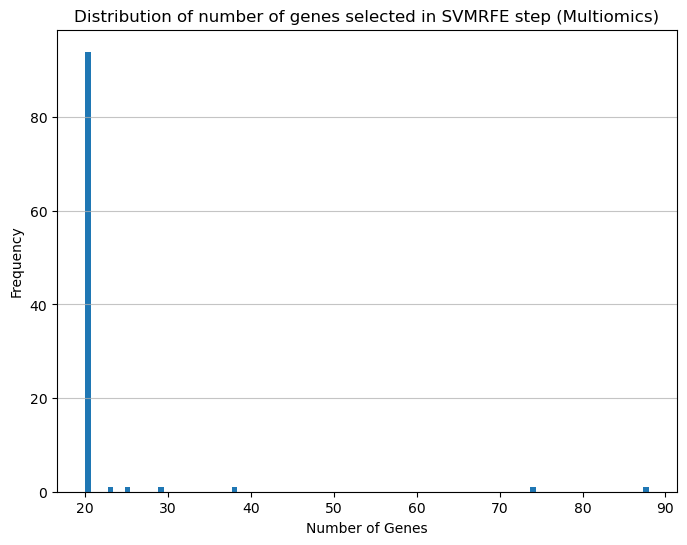

In [19]:
# histogram
plt.figure(figsize=(8,6))
plt.hist(num, bins = 100)
plt.title('Distribution of number of genes selected in SVMRFE step (Multiomics)')
plt.xlabel('Number of Genes', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(axis='y', alpha=0.75)
plt.show()


In [25]:
df_gene_freq = pd.DataFrame.from_dict(dict_gene_freq, orient="index")
df_gene_freq_svmrfe = df_gene_freq.sort_values(by = 0, ascending = False)
df_gene_freq_svmrfe.to_csv("results/MO/00-1_SVMRFE_GENEFreq_MO.csv")
df_gene_freq_svmrfe.head(20)

,0
P_HPX,93
P_SERPINA6,66
T_ETFDH,61
P_NOSTRIN,59
P_SERPINA1,57
P_SH3BGRL2,57
P_ORM2,46
P_SERPING1,39
P_SERPINA7,33
T_ASPA,30


### RFSFM

In [26]:
# finding the most reoccuring top 10 genes from SVMRFE
num = []
dict_gene_freq = {}

for key in dict_rfsfm.keys():
    num.append(len(dict_rfsfm[key]))
    for gene in dict_rfsfm[key]:
        if gene in dict_gene_freq:
            dict_gene_freq[gene] += 1
        else:
            dict_gene_freq[gene] = 1
len(dict_rfsfm), len(num)

(100, 100)

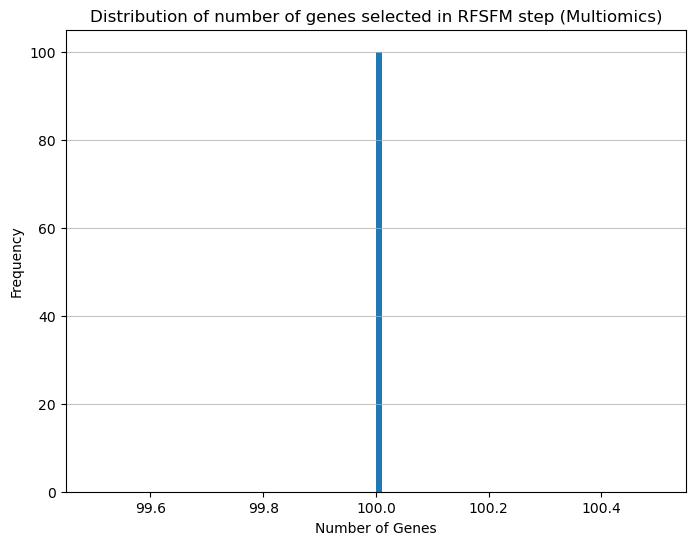

In [27]:
# histogram
plt.figure(figsize=(8,6))
plt.hist(num, bins = 100)
plt.title('Distribution of number of genes selected in RFSFM step (Multiomics)')
plt.xlabel('Number of Genes', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(axis='y', alpha=0.75)
plt.show()


In [28]:
df_gene_freq = pd.DataFrame.from_dict(dict_gene_freq, orient="index")
df_gene_freq_svmrfe = df_gene_freq.sort_values(by = 0, ascending = False)
df_gene_freq_svmrfe.to_csv("results/MO/00-1_RFSFM_GENEFreq_MO.csv")
df_gene_freq_svmrfe.head(20)

,0
P_CAB39L,100
P_ASPA,100
P_SH3BGRL2,99
P_LYVE1,97
P_TF,96
T_F10,96
P_HPX,96
P_ALB,95
P_PID1,95
T_SASH1,92


## Accuracy box plot for Cross validation across models 

### Statistical test

In [14]:
df_acc_cv = pd.read_csv("results/MO/00-1_Accuracy_CV_SVMRFE_MO.csv", index_col = 0)
df_acc_cv_random = pd.read_csv("results/MO/00-1_Accuracy_CV_Random_MO.csv", index_col = 0)
df_acc_pred = pd.read_csv("results/MO/00-1_Accuracy_Pred_SVMRFE_MO.csv", index_col = 0)
df_acc_pred_random = pd.read_csv("results/MO/00-1_Accuracy_Pred_Random_MO.csv", index_col =0 )

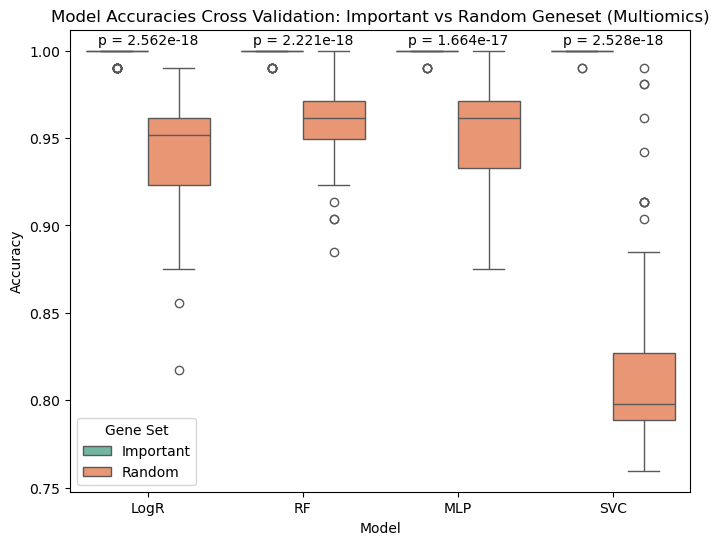

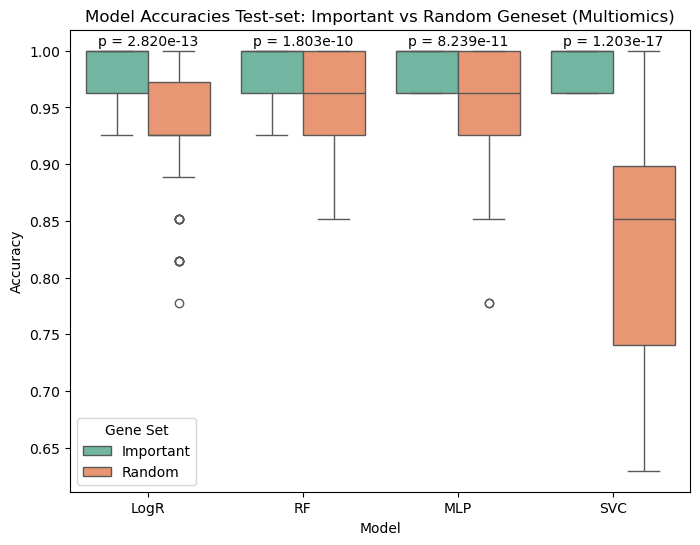

In [17]:
filepath = "results/MO/00-1_Fig_Acc_CV_MO.jpeg"
title = "Model Accuracies Cross Validation: Important vs Random Geneset (Multiomics)"
measure_boxplot(df_acc_cv, df_acc_cv_random, filepath, title)
filepath = "results/MO/00-1_Fig_Acc_pred_MO.jpeg"
title = "Model Accuracies Test-set: Important vs Random Geneset (Multiomics)"
measure_boxplot(df_acc_pred, df_acc_pred_random, filepath, title)


### Final classification task on slected genes 

In [4]:
df_gene_freq_svmrfe = pd.read_csv("results/MO/00-1_SVMRFE_GENEFreq_MO.csv", index_col = 0)

In [7]:
final_gene_set = list(df_gene_freq_svmrfe.head(20).index)
final_gene_set

['P_HPX',
 'P_SERPINA6',
 'T_ETFDH',
 'P_NOSTRIN',
 'P_SERPINA1',
 'P_SH3BGRL2',
 'P_ORM2',
 'P_SERPING1',
 'P_SERPINA7',
 'T_ASPA',
 'PP_IFI35',
 'P_SERPINA3',
 'T_LOC105373265',
 'P_PID1',
 'T_ADAM12',
 'P_LYVE1',
 'T_QARS',
 'T_MMRN1',
 'PP_TRPM6',
 'P_AGT']